<a href="https://colab.research.google.com/github/sammiesdad/LBCSI/blob/main/AI_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Configure our environment...

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
print("----->>>  tf version: ", tf.__version__)
import tensorflow_datasets as tfds

----->>>  tf version:  2.15.0


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


Count the images in the dataset.  Should be over 3500.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Show us the roses in the dataset and display one from the loaded array

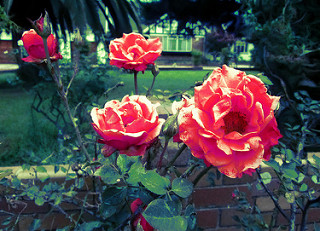

In [13]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[150]))


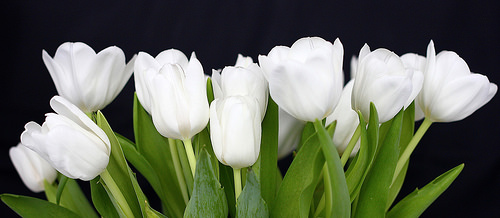

In [32]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

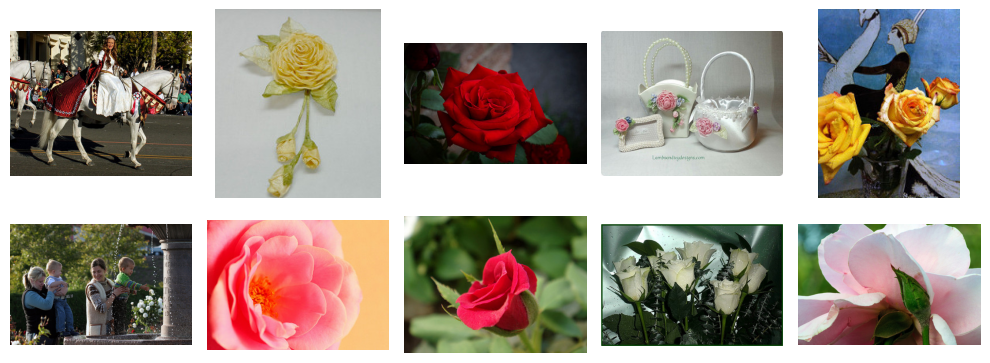

In [31]:
# show a matrix of 10 random roses from roses = list(data_dir.glob('roses/*'))

import matplotlib.pyplot as plt

# Select 10 random roses
random_roses = np.random.choice(roses, size=10, replace=False)

# Create a figure and subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Display the random roses in a grid
for i, ax in enumerate(axes.flat):
    img = PIL.Image.open(str(random_roses[i]))
    ax.imshow(img)
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


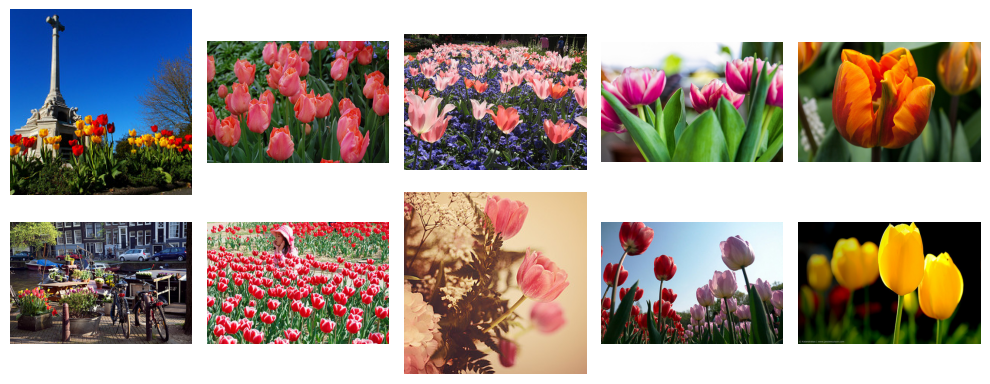

In [37]:
# show a matrix of 10 random tulips from tulips = list(data_dir.glob('tulips/*'))

import matplotlib.pyplot as plt

# Select 10 random tulips
random_tulips = np.random.choice(tulips, size=10, replace=False)

# Create a figure and subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Display the random tulips in a grid
for i, ax in enumerate(axes.flat):
    img = PIL.Image.open(str(random_tulips[i]))
    ax.imshow(img)
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

REMEMBER THE 80:20 RULE!!

In [15]:
#Training Data Set
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [19]:
# Show class names from training
train_class_names = train_ds.class_names
print(train_class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [17]:
#Validation Data Set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [18]:
# Show class names from training
val_class_names = val_ds.class_names
print(val_class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


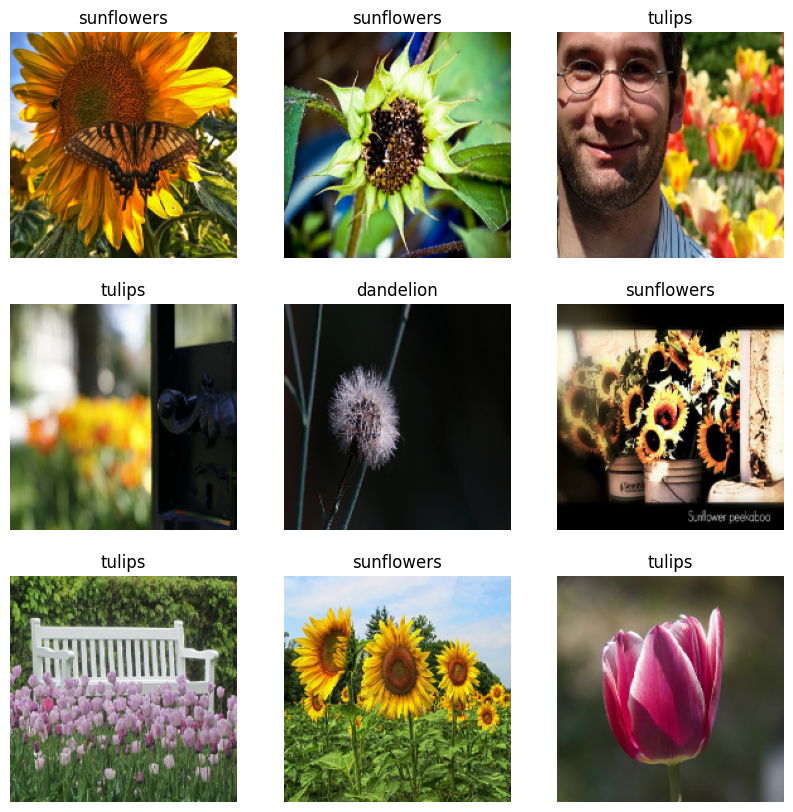

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")

Let's create a tensor called "image_batch".  It is a batch of 32 images, with a SHAPE of 180X180X3 (3 is the color dimension...  RGB = X channels?)

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Now - standardize the data!  These are jpeg images in RGB format.  What are the color values for RGB?  (hint....).  Neural networks process best on small numbers, so we'll standardize all these values between 0 and 1.  Let's create a LAYER (some defined math process) to apply against our tensor.

In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Apply the normalization layer against the dataset using dataset (.map).

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


Create prefetching caches to improve model performance.  This is important for application scaling!!!  Always cache or index datasets - especially with dense media files!

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**MODEL TRAINING!**
We'll be training using a variety of keras layers to create tensor dimensions to our image datasets and create differing parameters.  This is basically the "learning portion" of our model creation.

In [28]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)


Epoch 1/3
92/92 [==============================] - 117s 1s/step - loss: 1.2903 - accuracy: 0.4530 - val_loss: 1.1010 - val_accuracy: 0.5531
Epoch 2/3
92/92 [==============================] - 106s 1s/step - loss: 0.9906 - accuracy: 0.6073 - val_loss: 1.0043 - val_accuracy: 0.6117
Epoch 3/3
92/92 [==============================] - 110s 1s/step - loss: 0.8506 - accuracy: 0.6761 - val_loss: 0.9464 - val_accuracy: 0.6431


In [75]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Let's check our newly imported dataset to see how many classes (labels) it should have.... (aka, 5)

In [77]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Retrieve an image from the dataset....

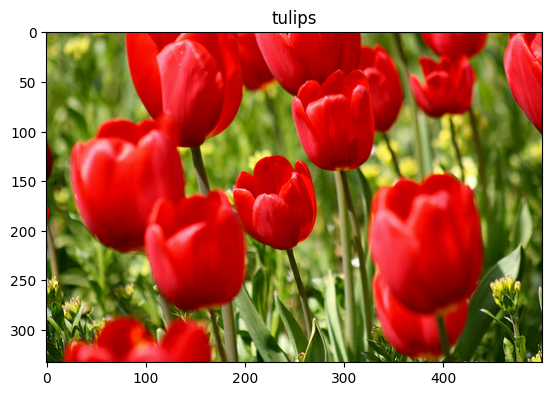

In [83]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

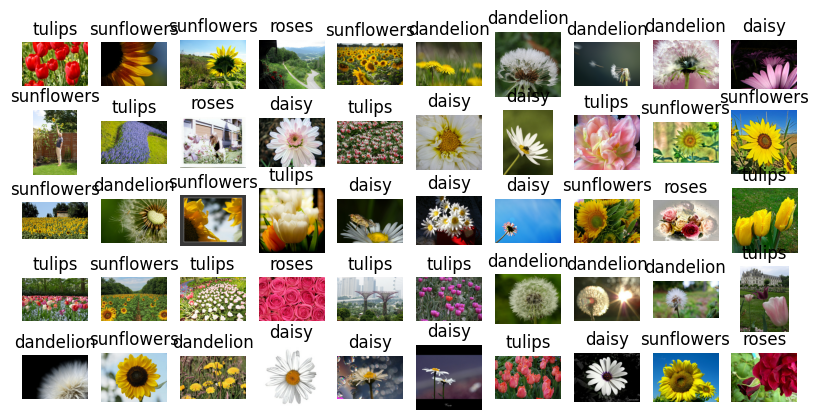

In [78]:
# show a grid of 100 images from dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(50)):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.axis("off")


In [72]:
# DO NOT EXECUTE!
# batch, shuffle and configure for performance

train_ds = train_ds.batch(batch_size=32).shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size=32).shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size=32).shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)


In [79]:
from tensorflow.keras import layers

Min and max pixel values: 0.0 1.0


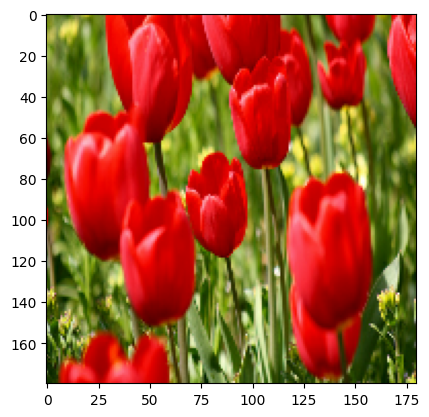

In [85]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])
result = resize_and_rescale(image)
_ = plt.imshow(result)
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

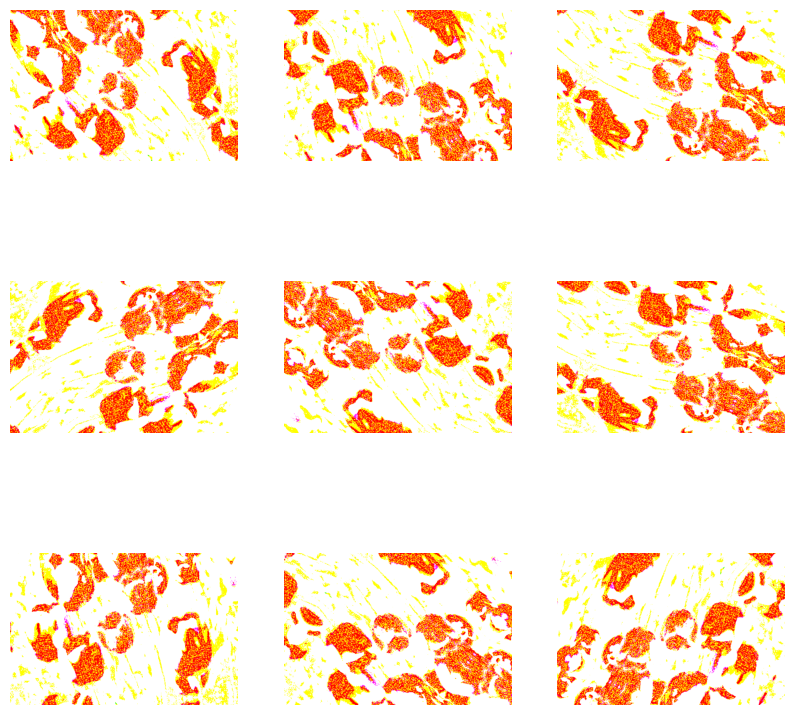

In [86]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [87]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [88]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [90]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

92/92 [==============================] - 105s 1s/step - loss: 1.4314 - accuracy: 0.3937 - val_loss: 1.1343 - val_accuracy: 0.5232


In [91]:
#Validate Accuracy
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 299ms/step - loss: 1.1079 - accuracy: 0.5232
Accuracy 0.5231607556343079


Create CUSTOM LAYERS via Lambda

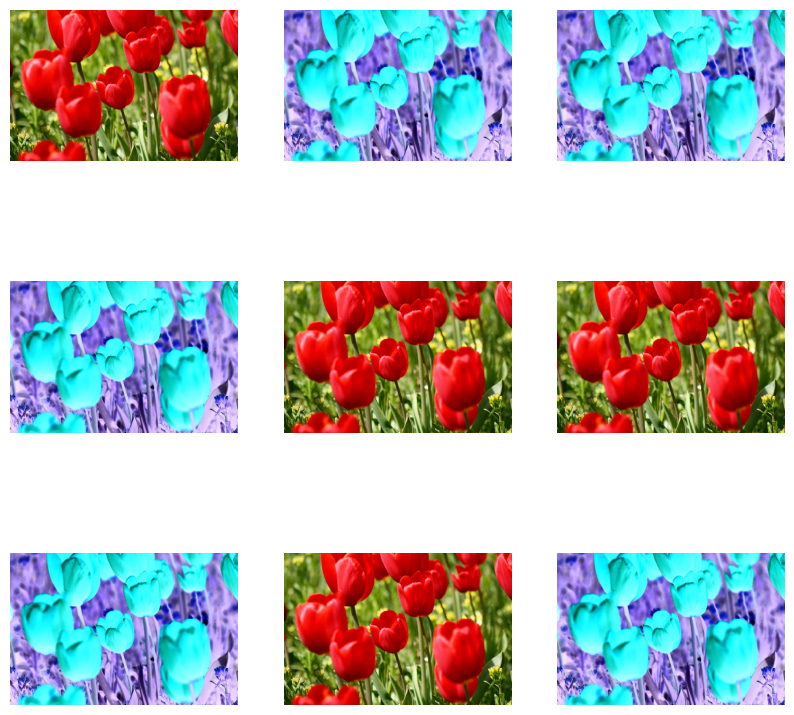

In [96]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

# Visualize the layers
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

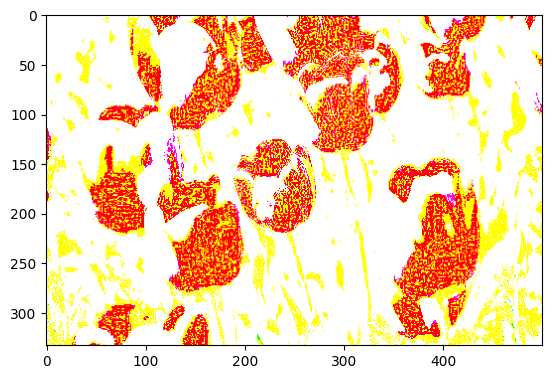

In [102]:
# Implement the new layer
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

_ = plt.imshow(RandomInvert()(image)[0])